In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_colwidth', -1)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import csv
import urllib
import time

#Exploratory Data Analysis

Before beginning in-depth modeling, it's good to get a sense of what our data looks like. Perhaps we can see what variables seem to have relationships with one another which can form a basis for predictive modeling.

##Visualizing the Air Pollutant Data

In [2]:
#Load in the 3 US datasets
YearDat = pd.read_csv('YearDat.csv')
MonthDat = pd.read_csv('MonthDat.csv')
SeasonDat = pd.read_csv('SeasonDat.csv')

One of the best first steps is the get a sense the distribution of the various variables in the dataset. We can start by looking at the distribution of the several pollutants in our dataset to see how they vary by site. To begin with, we can look at distributions of the pollutants through monthly and seasonal time periods.

In [3]:
#Generate a mapper to get Month Labels for plots
mapper = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'June',7:'July',8:'Aug',9:'Sept',10:'Oct',11:'Nov',12:'Dec'}
MonthDatMapped = MonthDat.copy()
MonthDatMapped['Month']=MonthDatMapped['month'].map(mapper.get)

C:\Users\Mark\Anaconda\lib\site-packages\matplotlib\figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


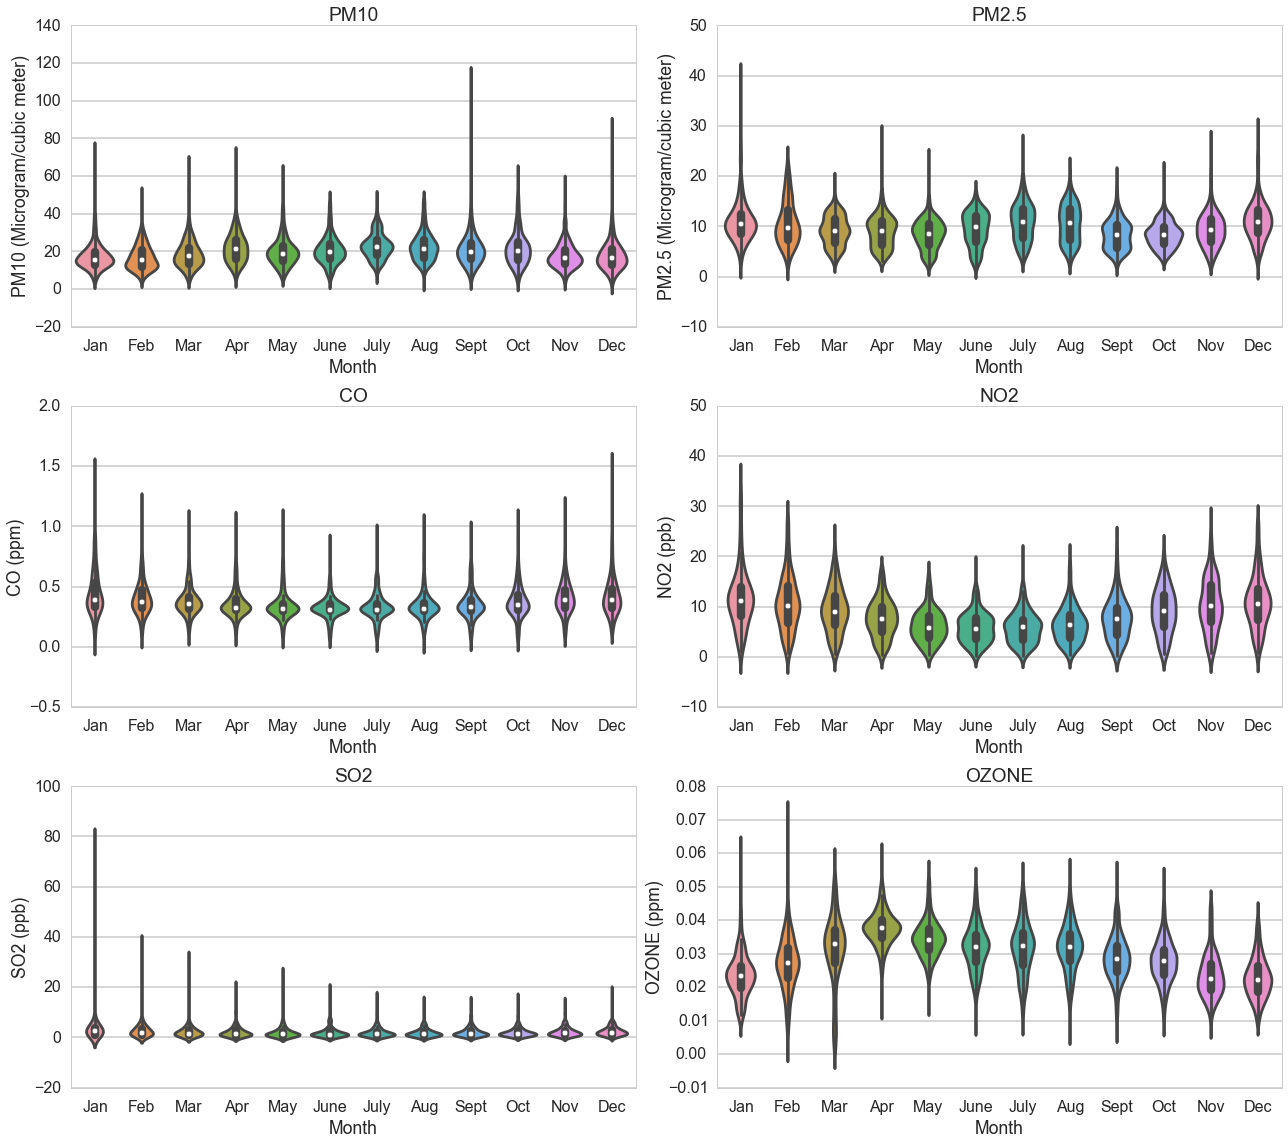

In [4]:
#Create 6 plots, one for each pollutant
#Then make a violin-plot of that pollutant
#for each month
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 16))
fig.set_tight_layout(True)
sns.violinplot(x='Month',y='PM10',data=MonthDatMapped, ax = axes[0,0])
axes[0,0].set_title('PM10')
axes[0,0].set_ylabel('PM10 (Microgram/cubic meter)')
sns.violinplot(x='Month',y='PM25_FRMFEM',data=MonthDatMapped, ax = axes[0,1])
axes[0,1].set_title('PM2.5')
axes[0,1].set_ylabel('PM2.5 (Microgram/cubic meter)')
sns.violinplot(x='Month',y='CO',data=MonthDatMapped, ax = axes[1,0])
axes[1,0].set_title('CO')
axes[1,0].set_ylabel('CO (ppm)')
sns.violinplot(x='Month',y='NO2',data=MonthDatMapped, ax = axes[1,1])
axes[1,1].set_title('NO2')
axes[1,1].set_ylabel('NO2 (ppb)')
sns.violinplot(x='Month',y='SO2',data=MonthDatMapped, ax = axes[2,0])
axes[2,0].set_title('SO2')
axes[2,0].set_ylabel('SO2 (ppb)')
sns.violinplot(x='Month',y='OZONE',data=MonthDatMapped, ax = axes[2,1])
axes[2,1].set_title('OZONE')
axes[2,1].set_ylabel('OZONE (ppm)')

The above plots give us the distribution of each of the six air quality variables, distributed across the months of 2010. There are few takeaways:
1. There are a few outliers throughout the data. For example, there is a very high $SO_2$ value in January of 2010 for one site. This actually corresponds to the Hilo, HI site which is volcanically active. Volcanoes emit large levels of $SO_2$ so this isn't surprising.
2. The general distriubtion of all these metrics remains fairly consistent throughout the year. There are perhaps slight seasonal changes in ozone (smaller in the winter months) and $SO_2$ (larger in the winter months) but they are fairly minor in the grand scheme of things.
3. The variablility of most variables appears somewhat symmetric which is great for modeling purposes.

We can also look a little more carefully at season and monthly trends in the pollutants by looking at barcharts and line plots.

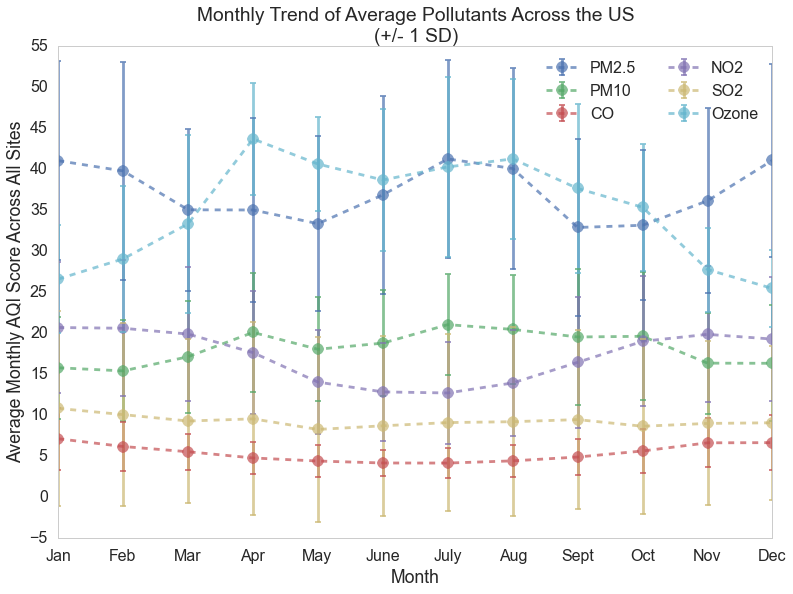

In [16]:
#Visualize the average pollutants monthly
#group all sites by month
group = MonthDat.groupby('month')
#Get the mean and sd over each month
plotVals = group.mean()
plotError = group.std()
#Initiate a plot and fill in the relevant info
fig, ax1 = plt.subplots()
plt.locator_params(nbins=12)
plt.grid(False)
plt.errorbar(plotVals.index,plotVals.AQI_PM25_FRMFEM, yerr=plotError.AQI_PM25_FRMFEM,label='PM2.5',alpha=.7,fmt='o--',capthick=2)
plt.errorbar(plotVals.index,plotVals.AQI_PM10, yerr=plotError.AQI_PM10,label='PM10',alpha=.7,fmt='o--',capthick=2)
plt.errorbar(plotVals.index,plotVals.AQI_CO, yerr=plotError.AQI_CO,label='CO',alpha=.7,fmt='o--',capthick=2)
plt.errorbar(plotVals.index,plotVals.AQI_NO2, yerr=plotError.AQI_NO2,label='NO2',alpha=.7,fmt='o--',capthick=2)
plt.errorbar(plotVals.index,plotVals.AQI_SO2, yerr=plotError.AQI_SO2,label='SO2',alpha=.7,fmt='o--',capthick=2)
plt.errorbar(plotVals.index,plotVals.AQI_OZONE, yerr=plotError.AQI_OZONE,label='Ozone',alpha=.7,fmt='o--',capthick=2)
#Format legend, axes, and title
ax1.set_xticklabels(('Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec'))
ax1.set_xlabel('Month')
ax1.set_ylabel("Average Monthly AQI Score Across All Sites")
ax1.legend(loc='upper right',ncol=2)
plt.title('Monthly Trend of Average Pollutants Across the US\n(+/- 1 SD)')

For the most part, things look farily consistent. We see slight increases in PM10 and Ozone in the summer months -- this makes sense as ozone levels are increased when it is hotter, especially during heatwaves and PM10 is affected similarly. $NO_2$ seems to generally be slighly higher in the winter months. This also makes a sense as $NO_2$ is primarily emitted from fuel combustion and transportation, both of which are likely higher in the colder winter months.

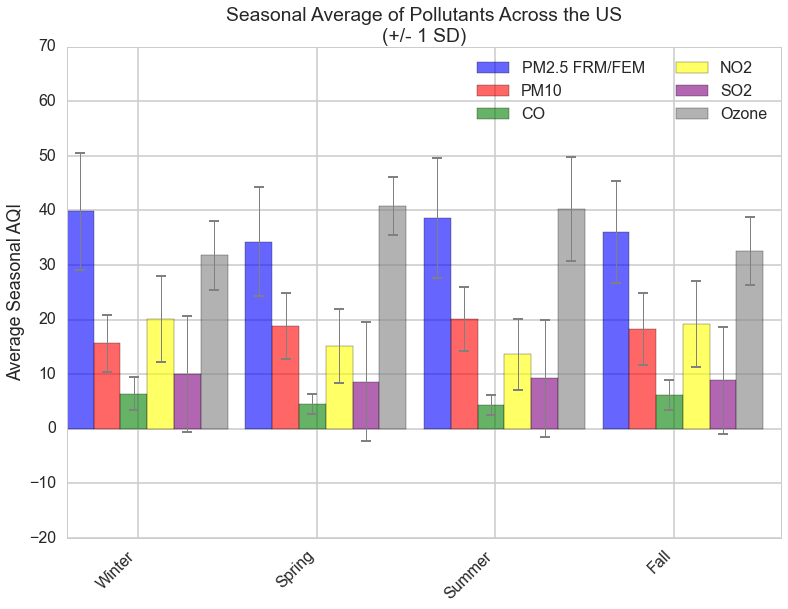

In [17]:
#Visualize the average pollutants by season
#Group by season
group = SeasonDat.groupby('season')
#Get group means and sd
plotVals = group.mean()
plotError = group.std()
#Intiate plots
fig, ax1 = plt.subplots()
#set the x-axis locations
x=[0,1,2,3]
#Plot bars and errors for each pollutant
pm25_bar=plt.bar(x,[float(plotVals[plotVals.index=='Winter']['AQI_PM25_FRMFEM']),float(plotVals[plotVals.index=='Spring']['AQI_PM25_FRMFEM']),
 float(plotVals[plotVals.index=='Summer']['AQI_PM25_FRMFEM']),float(plotVals[plotVals.index=='Fall']['AQI_PM25_FRMFEM'])],
                  width=.15,color='blue',alpha=.6,yerr=[float(plotError[plotError.index=='Winter']['AQI_PM25_FRMFEM']),float(plotError[plotError.index=='Spring']['AQI_PM25_FRMFEM']),
 float(plotError[plotError.index=='Summer']['AQI_PM25_FRMFEM']),float(plotError[plotError.index=='Fall']['AQI_PM25_FRMFEM'])],error_kw=dict(ecolor='gray', lw=1, capsize=5, capthick=2))

pm10_bar=plt.bar([i+.15 for i in x],[float(plotVals[plotVals.index=='Winter']['AQI_PM10']),float(plotVals[plotVals.index=='Spring']['AQI_PM10']),
 float(plotVals[plotVals.index=='Summer']['AQI_PM10']),float(plotVals[plotVals.index=='Fall']['AQI_PM10'])],
                  width=.15,color='red',alpha=.6,yerr=[float(plotError[plotError.index=='Winter']['AQI_PM10']),float(plotError[plotError.index=='Spring']['AQI_PM10']),
 float(plotError[plotError.index=='Summer']['AQI_PM10']),float(plotError[plotError.index=='Fall']['AQI_PM10'])],error_kw=dict(ecolor='gray', lw=1, capsize=5, capthick=2))

co_bar=plt.bar([i+.3 for i in x],[float(plotVals[plotVals.index=='Winter']['AQI_CO']),float(plotVals[plotVals.index=='Spring']['AQI_CO']),
 float(plotVals[plotVals.index=='Summer']['AQI_CO']),float(plotVals[plotVals.index=='Fall']['AQI_CO'])],
                  width=.15,color='green',alpha=.6,yerr=[float(plotError[plotError.index=='Winter']['AQI_CO']),float(plotError[plotError.index=='Spring']['AQI_CO']),
 float(plotError[plotError.index=='Summer']['AQI_CO']),float(plotError[plotError.index=='Fall']['AQI_CO'])],error_kw=dict(ecolor='gray', lw=1, capsize=5, capthick=2))

no2_bar=plt.bar([i+.45 for i in x],[float(plotVals[plotVals.index=='Winter']['AQI_NO2']),float(plotVals[plotVals.index=='Spring']['AQI_NO2']),
 float(plotVals[plotVals.index=='Summer']['AQI_NO2']),float(plotVals[plotVals.index=='Fall']['AQI_NO2'])],
                  width=.15,color='yellow',alpha=.6,yerr=[float(plotError[plotError.index=='Winter']['AQI_NO2']),float(plotError[plotError.index=='Spring']['AQI_NO2']),
 float(plotError[plotError.index=='Summer']['AQI_NO2']),float(plotError[plotError.index=='Fall']['AQI_NO2'])],error_kw=dict(ecolor='gray', lw=1, capsize=5, capthick=2))

so2_bar=plt.bar([i+.6 for i in x],[float(plotVals[plotVals.index=='Winter']['AQI_SO2']),float(plotVals[plotVals.index=='Spring']['AQI_SO2']),
 float(plotVals[plotVals.index=='Summer']['AQI_SO2']),float(plotVals[plotVals.index=='Fall']['AQI_SO2'])],
                  width=.15,color='purple',alpha=.6,yerr=[float(plotError[plotError.index=='Winter']['AQI_SO2']),float(plotError[plotError.index=='Spring']['AQI_SO2']),
 float(plotError[plotError.index=='Summer']['AQI_SO2']),float(plotError[plotError.index=='Fall']['AQI_SO2'])],error_kw=dict(ecolor='gray', lw=1, capsize=5, capthick=2))

ozone_bar=plt.bar([i+.75 for i in x],[float(plotVals[plotVals.index=='Winter']['AQI_OZONE']),float(plotVals[plotVals.index=='Spring']['AQI_OZONE']),
 float(plotVals[plotVals.index=='Summer']['AQI_OZONE']),float(plotVals[plotVals.index=='Fall']['AQI_OZONE'])],
                  width=.15,color='grey',alpha=.6,yerr=[float(plotError[plotError.index=='Winter']['AQI_OZONE']),float(plotError[plotError.index=='Spring']['AQI_OZONE']),
 float(plotError[plotError.index=='Summer']['AQI_OZONE']),float(plotError[plotError.index=='Fall']['AQI_OZONE'])],error_kw=dict(ecolor='gray', lw=1, capsize=5, capthick=2))

#Clean up the axes
plt.xticks([i+.4 for i in x],['Winter','Spring','Summer','Fall'],rotation=45,ha='right')
ax1.set_ylim(-20,70)
plt.ylabel('Average Seasonal AQI')
plt.legend((pm25_bar,pm10_bar,co_bar,no2_bar,so2_bar,ozone_bar),('PM2.5 FRM/FEM','PM10','CO','NO2','SO2','Ozone'),ncol=2)
plt.title('Seasonal Average of Pollutants Across the US\n(+/- 1 SD)')

In general, it appears that there are not terribly strong seasonal and monthly changes based on this data. This suggests that it may just be easiest to look at yearly average for each site. Let's take a look at how the different outcome metrics related to one another by looking at scatterplots and basic correlations. At the same time, we can also look at some basic histograms which should reflect the violinplot distributions we saw earlier, except on a whole year basis.

Correlation Between OZONE and PM10: 0.0287011702891 (p=0.680688000502)
Correlation Between OZONE and PM25_FRMFEM: -0.0695559512412 (p=0.224282391065)
Correlation Between OZONE and SO2: 0.165851880628 (p=0.032190408189)
Correlation Between PM10 and PM25_FRMFEM: 0.360217553036 (p=3.09582904393e-08)
Correlation Between PM10 and SO2: 0.0949760968437 (p=0.275010121956)
Correlation Between PM25_FRMFEM and SO2: 0.282720146792 (p=0.000291989783417)
Correlation Between NO2 and OZONE: -0.0395821595715 (p=0.629421650759)
Correlation Between NO2 and PM10: 0.360798210752 (p=3.32088628671e-05)
Correlation Between NO2 and PM25_FRMFEM: 0.300902850694 (p=0.000319021663199)
Correlation Between NO2 and SO2: 0.132770628106 (p=0.162854356882)
Correlation Between CO and OZONE: -0.169005577196 (p=0.0436106179851)
Correlation Between CO and PM10: 0.180403245246 (p=0.0432324988925)
Correlation Between CO and PM25_FRMFEM: -0.010052061282 (p=0.90650756402)
Correlation Between CO and NO2: 0.443945785541 (p=2.3533

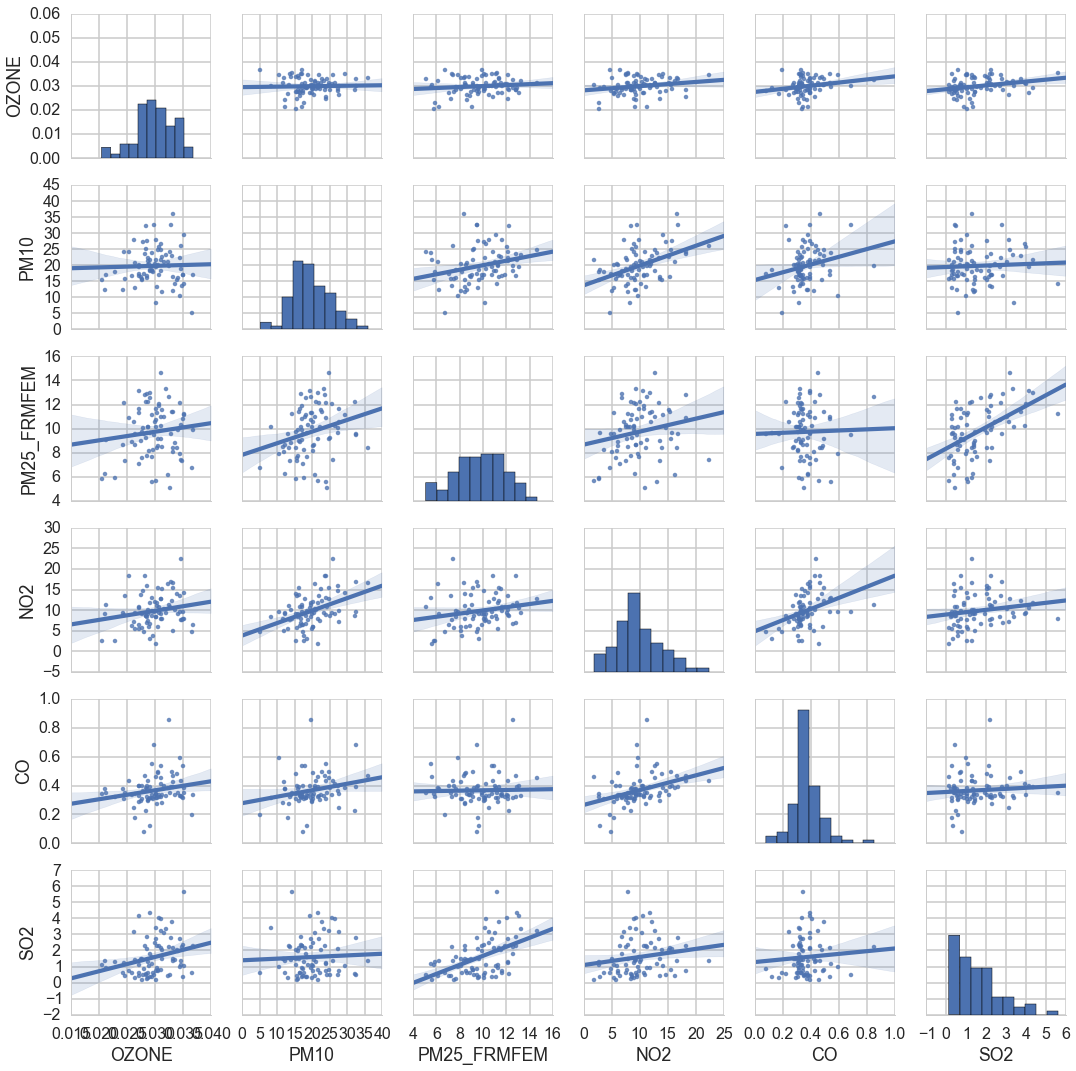

In [49]:
#Get correlations between each pair of pollutants
#list pollutants
pollutants = ['OZONE','PM10','PM25_FRMFEM','NO2','CO','SO2']
#loop through this list twice
#keeping track of the index of each loop
count1 = 0
for i in pollutants:
    count1 += 1
    count2 = 0
    for j in pollutants:
        count2 += 1
        #When the index of the second is bigger than the first,
        #we have a unique pair
        if j > i:
            #Get non-missing arguments for each pair
            index1 = []
            index2 = []
            for p,x in enumerate(pd.notnull(YearDat[[i]]).values):
                if x[0]:
                    index1.append(p)
            for p,x in enumerate(pd.notnull(YearDat[[j]]).values):
                if x[0]:
                    index2.append(p)
            touse = list(set(index2).intersection(index1))
            #Subset the dataset to just non-missing data
            a = YearDat[[i,j]]
            a = a.loc[touse]
            #Get correlation and print info
            print 'Correlation Between '+i+' and '+j+": " +str(sp.stats.pearsonr(a[i],a[j])[0])+" (p="+str(sp.stats.pearsonr(a[i],a[j])[1])+")"
#Make a pairplot
myplot = sns.pairplot(YearDat[['OZONE','PM10','PM25_FRMFEM','NO2','CO','SO2']].dropna(),kind='reg')

The distributions of each pollutant reflects well what we were seeing in the violin plots. Most things are fairly symmetrically distributed with the exception of $SO_2$ which has long tails. We definitely are seeing a range of variation across the different metrics which will make them interesting for modeling purposes.

Some pollutants definitely appear more correlated than others. $NO_2$ and $CO$ have a highly significant correlation of about 0.44 (p<0.01). $NO_2$ also seems fairly correlated with PM2.5 and and PM10 (r=0.30 and r=0.36, p<0.01). This suggests that perhaps three variables share similar trends and maybe have similar causes. Other pollutants are not nearly as correlated though suggesting different sources of pollution. This gives us an idea of how well we can potentially develop 'pollutant profiles' based on differences in these pollutants.

##Visualizing Prediction Data

Now that we have a pretty good idea of what our pollutant data looks like and how each pollutant relates to one another, we can move forward and look at our predictors. We want to get a sense of what this data looks like before trying to build any models that relate the two together.

###Weather Data
Starting with the weather data we pretty much see the expected trends at the monthly level.

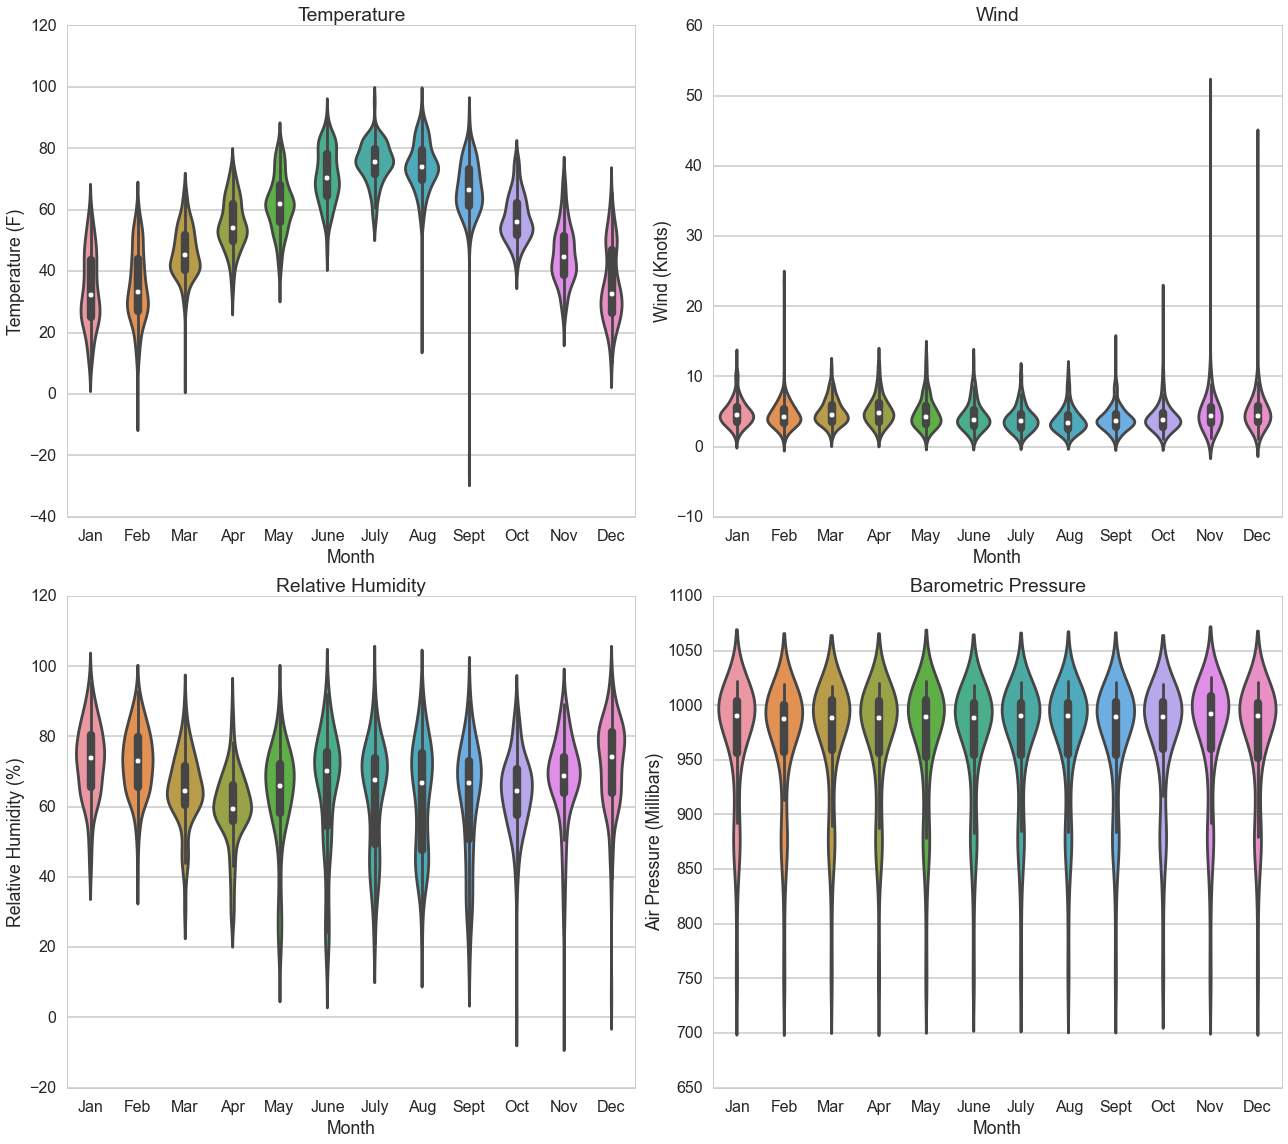

In [50]:
#Violin plots of weather data
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 16))
fig.set_tight_layout(True)
sns.violinplot(x='Month',y='TEMP',data=MonthDatMapped, ax = axes[0,0])
axes[0,0].set_title('Temperature')
axes[0,0].set_ylabel('Temperature (F)')
sns.violinplot(x='Month',y='WIND',data=MonthDatMapped, ax = axes[0,1])
axes[0,1].set_title('Wind')
axes[0,1].set_ylabel('Wind (Knots)')
sns.violinplot(x='Month',y='RH',data=MonthDatMapped, ax = axes[1,0])
axes[1,0].set_title('Relative Humidity')
axes[1,0].set_ylabel('Relative Humidity (%)')
sns.violinplot(x='Month',y='PRESS',data=MonthDatMapped, ax = axes[1,1])
axes[1,1].set_title('Barometric Pressure')
axes[1,1].set_ylabel('Air Pressure (Millibars)')

With the exception of temperature, we don't see too strong of seasonal changes in the other weather indicators. Variation does seem to have some seasonality for wind and perhaps relative humidity. This means it may be a bit too course to simply look at the overall year, but it still seems like a good place to start in the modeling.

###Demographics and Traffic Data

We can visualize the demographic information using basic histograms. First, we see that most of our areas are metropolitan statistical areas based on the distribution below.

[<matplotlib.text.Text at 0x3906bf28>, <matplotlib.text.Text at 0x314d0518>]

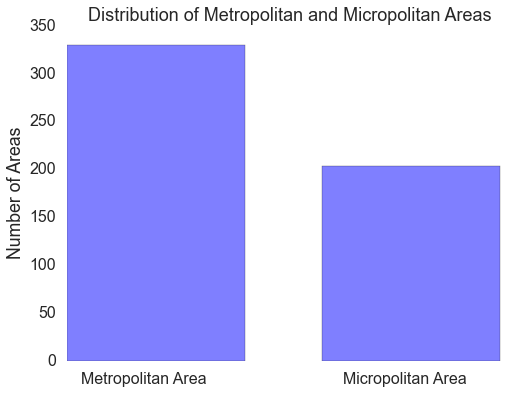

In [267]:
fig, ax = plt.subplots(figsize=(8,6))
rects1 = ax.bar([0,.4],[YearDat['MetArea'].value_counts()[0],YearDat['MetArea'].value_counts()[1]], .28, color='b',alpha=0.5)
ax.grid('off')
#http://stackoverflow.com/questions/14908576/how-to-remove-frame-from-matplotlib-pyplot-figure-vs-matplotlib-figure-frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
# add some text for labels, title and axes ticks
ax.set_ylabel('Number of Areas')
ax.set_title('Distribution of Metropolitan and Micropolitan Areas',fontsize=18)
ax.set_xticks([.12,.53])
ax.set_xticklabels( ('Metropolitan Area', 'Micropolitan Area') )

Next, we see that the demographics vary quite a bit across our sites in terms of total population, area, and population density.

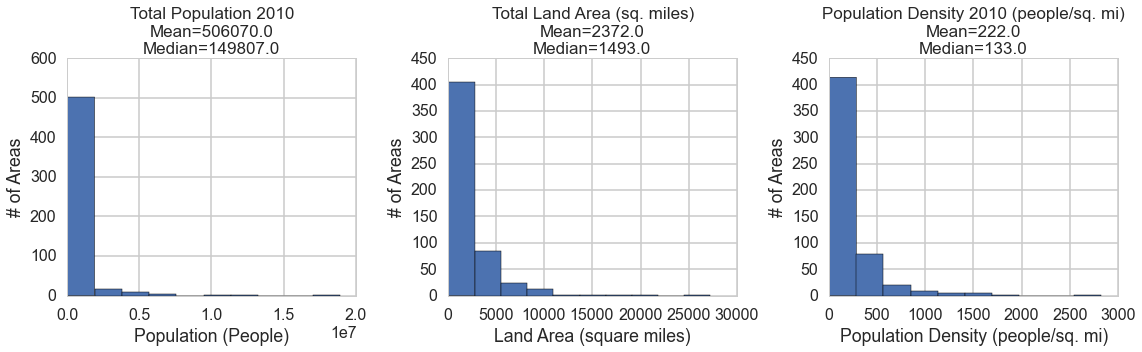

In [154]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))
fig.set_tight_layout(True)
titlemap = {'pop2010':'Total Population 2010','landarea':'Total Land Area (sq. miles)','popdense2010':'Population Density 2010 (people/sq. mi)'}
xmap = {'pop2010':'Population (People)','landarea':'Land Area (square miles)','popdense2010':'Population Density (people/sq. mi)'}
a=np.array(YearDat[pd.notnull(YearDat['pop2010'])]['pop2010'])
for i,j in zip(axes.ravel(),['pop2010','landarea','popdense2010']):
    i.hist(YearDat[pd.notnull(YearDat[j])][j])
    i.set_title(titlemap[j]+'\nMean='+str(round(YearDat[pd.notnull(YearDat[j])][j].mean(),0))
                +'\nMedian='+str(round(YearDat[pd.notnull(YearDat[j])][j].median(),0)),fontsize=17)
    i.set_ylabel('# of Areas')
    i.set_xlabel(xmap[j])
    



We see that most demographics are heavily skewed as there are a few regions (like NYC) that are much larger in people and density. The population has a median of about 150,000 people, the land are median is about 1500 sq. miles, and the median density is about 133 peope/square mile.

For visualizing the mode of commuting, it is really easy to see this using a map. The following code generates a dataframe that allows us to make the next visualization.

In [237]:
TransitMode = YearDat[['CBSA Name','alone_frac','carpool_frac','other_frac','pt_frac','total_trans']]
TransitMode.dropna(inplace=True)
TransitMode['car_frac']=TransitMode['alone_frac']+TransitMode['carpool_frac']

C:\Users\Mark\Anaconda\lib\site-packages\IPython\kernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app
C:\Users\Mark\Anaconda\lib\site-packages\IPython\kernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [235]:
TransitMode['alone_frac']=TransitMode['alone_frac'].apply(lambda x: round(x,3))
TransitMode['pt_frac']=TransitMode['pt_frac'].apply(lambda x: round(x,3))
TransitMode['carpool_frac']=TransitMode['carpool_frac'].apply(lambda x: round(x,3))
TransitMode['car_frac']=TransitMode['car_frac'].apply(lambda x: round(x,3))
TransitMode['other_frac']=TransitMode['other_frac'].apply(lambda x: round(x,3))

C:\Users\Mark\Anaconda\lib\site-packages\IPython\kernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Mark\Anaconda\lib\site-packages\IPython\kernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app
C:\Users\Mark\Anaconda\lib\site-packages\IPython\kernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the t

In [265]:
newFrame = {}
newFrame['CBSA Name'] = []
newFrame['Mode'] = []
newFrame['Total'] = []
for i in range(TransitMode.shape[0]):
    newFrame['CBSA Name'] = newFrame['CBSA Name'] + [TransitMode.iloc[i]['CBSA Name']]*100
    newFrame['Total'] = newFrame['Total']+[TransitMode.iloc[i]['total_trans']]*100
    newFrame['Mode'] = newFrame['Mode']+int("%.0f" % (TransitMode.iloc[i]['carpool_frac']*100))*['Carpool']+int("%.0f" % (TransitMode.iloc[i]['other_frac']*100))*['Other']+int("%.0f" % (TransitMode.iloc[i]['pt_frac']*100))*['Public Transportation']+int("%.0f" % (TransitMode.iloc[i]['alone_frac']*100))*['Drive Alone']
    if int("%.0f" % (TransitMode.iloc[i]['alone_frac']*100)) + int("%.0f" % (TransitMode.iloc[i]['other_frac']*100)) + int("%.0f" % (TransitMode.iloc[i]['carpool_frac']*100)) + int("%.0f" % (TransitMode.iloc[i]['pt_frac']*100)) >100:
        del newFrame['Mode'][-1]
    if int("%.0f" % (TransitMode.iloc[i]['alone_frac']*100)) + int("%.0f" % (TransitMode.iloc[i]['other_frac']*100)) + int("%.0f" % (TransitMode.iloc[i]['carpool_frac']*100)) + int("%.0f" % (TransitMode.iloc[i]['pt_frac']*100)) <100:
        newFrame['Mode'].append('Drive Alone')
pd.DataFrame(newFrame).to_csv('us_transit_to_tableu.csv')

Using Tableau, we can visualize the population density by CBSA as well as the preferred mode of transportation: 

<img src='TransitMap.png' style="width:1200px; display:inline-block;">

###Basic Linear Modeling of Pollutants

Now that we've seen how are basic outcomes and predictors behave, we can start to see if we can predict them using some basic linear models. At this point, it makes most sense to predict the single outcome variables (pollutants) separately as a product of the other predictors. We will do just that in the next section.

In [268]:
import statsmodels.api as sm
from statsmodels.formula.api import glm, ols

In [310]:
YearDat['car_frac'] = YearDat['carpool_frac']+YearDat['alone_frac']

In [311]:
YearDat['pt_other_frac'] = YearDat['pt_frac']+YearDat['other_frac']

In [332]:
coF = YearDat[pd.notnull(YearDat['CO'])]

In [349]:
import numpy as np
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='median', axis=0)
imp.fit(np.array(coF[['NO2','WIND','PRESS','RH','TEMP','popdense2010','pt_frac']]))
X = np.array(coF[['NO2','WIND','PRESS','RH','TEMP','popdense2010','pt_frac']])
imputedFrame = pd.DataFrame(imp.transform(X))
imputedFrame.columns = ['NO2','WIND','PRESS','RH','TEMP','popdense2010','pt_frac']

In [350]:
imputedFrame.head()

,NO2,WIND,PRESS,RH,TEMP,popdense2010,pt_frac
0,9.086530,4.054361,992.901278,66.766960,54.730585,781.2,0.013025
1,9.086530,4.379985,987.099065,70.302359,49.955625,309.7,0.029408
2,12.101614,4.054361,824.934144,39.531011,58.734030,95.6,0.015291
3,10.760570,4.054361,992.901278,66.766960,54.730585,565.1,0.012641
4,9.086530,4.054361,992.901278,66.766960,54.730585,14.5,0.016300


In [351]:
ols_model = ols('NO2 ~ WIND + TEMP + pt_frac + popdense2010 + PRESS + RH',imputedFrame).fit()
ols_model
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    NO2   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     9.383
Date:                Mon, 30 Nov 2015   Prob (F-statistic):           1.15e-08
Time:                        21:49:40   Log-Likelihood:                -369.66
No. Observations:                 149   AIC:                             753.3
Df Residuals:                     142   BIC:                             774.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept       37.1438      8.072      4.601      0.000        21.186    53.101
WIND             0.0463      0.143      0.323      0.747        -0.237     0.330
TEMP            -0.0354      0.036     -0.979      0.329        -0.107     0.036
pt_frac         24.0755      9.905      2.431      0.016         4.496    43.655
popdense2010     0.0019      0.001      2.535      0.012         0.000     0.003
PRESS           -0.0188      0.008     -2.252      0.026        -0.035    -0.002
RH              -0.1356      0.034     -3.976      0.000        -0.203    -0.068
==============================================================================
Omnibus:                        6.963   Durbin-Watson:                   1.835
Prob(Omnibus):                  0.031   Jarque-Bera (JB):               10.101
Skew:                          -0.212   Prob(JB):                      0.00641
Kurtosis:                       4.203   Cond. No.                     4.45e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.45e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   PM10   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     3.779
Date:                Mon, 30 Nov 2015   Prob (F-statistic):            0.00108
Time:                        21:45:32   Log-Likelihood:                -1514.2
No. Observations:                 533   AIC:                             3042.
Df Residuals:                     526   BIC:                             3072.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept        13.3390      7.090      1.881      0.060        -0.590    27.268
WIND             -0.0786      0.147     -0.535      0.593        -0.367     0.210
TEMP              0.0778      0.032      2.412      0.016         0.014     0.141
pt_other_frac    -8.3306      5.744     -1.450      0.148       -19.616     2.954
popdense2010      0.0003      0.001      0.531      0.595        -0.001     0.002
PRESS             0.0097      0.008      1.282      0.200        -0.005     0.025
RH               -0.0916      0.034     -2.733      0.006        -0.158    -0.026
==============================================================================
Omnibus:                      280.289   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4570.526
Skew:                           1.907   Prob(JB):                         0.00
Kurtosis:                      16.830   Cond. No.                     3.96e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.96e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

C:\Users\Mark\Anaconda\lib\site-packages\matplotlib\figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


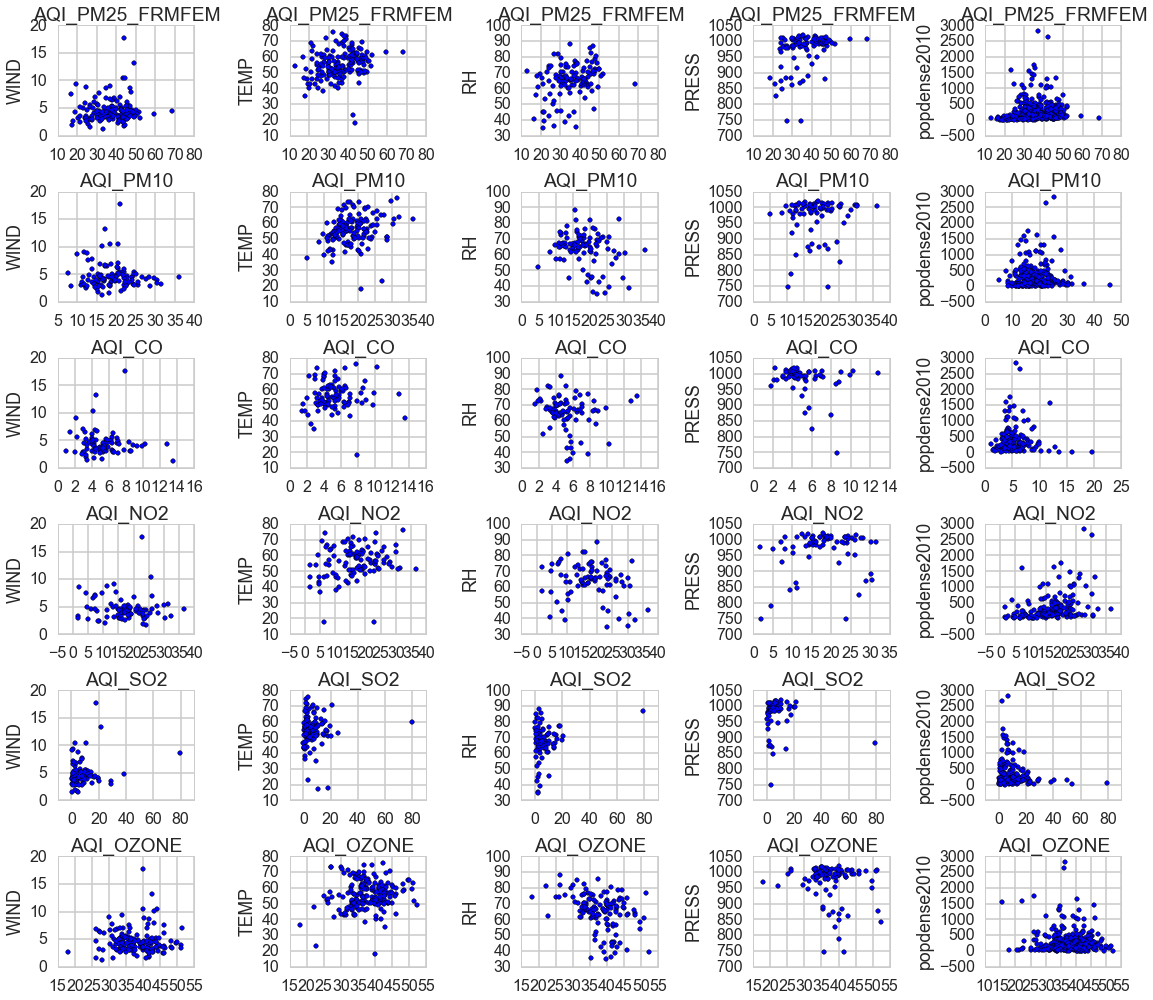

In [9]:
outcomes = ['AQI_PM25_FRMFEM',"AQI_PM10","AQI_CO","AQI_NO2",'AQI_SO2','AQI_OZONE']
predictors = ['WIND','TEMP','RH','PRESS','popdense2010']
fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(16, 14), 
                         tight_layout=True)
count = 0
for pol in outcomes:
    for pred in predictors:
        ax = axes.ravel()[count]
        plotting_dat = YearDat[[pol,pred]]
        ax.scatter(plotting_dat[pol],plotting_dat[pred])
        count += 1
        ax.set_title(pol)
        ax.set_ylabel(pred)
        #ax.annotate(pol, xy=(np.min(plotting_dat[pol]), np.max(plotting_dat[pred])), fontsize=14)

In [17]:
MonthDatMapped

,CBSA Name,month,Latitude,Longitude,PM25_FRMFEM,AQI_PM25_FRMFEM,PM25_NOFRMFEM,AQI_PM25_NOFRMFEM,PM10,AQI_PM10,TEMP,PRESS,RH,DP,WIND,CO,AQI_CO,NO2,AQI_NO2,OZONE,AQI_OZONE,SO2,AQI_SO2,id,MetArea,pop2010,landarea,popdense2010,pop_weight2010,alone,alone_frac,carpool,carpool_frac,other,other_frac,pt,pt_frac,total_trans,Month
0,"Aberdeen, SD",1,45.462500,-98.486111,12.340000,46.800000,NaN,NaN,14.400000,13.400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10100,Micropolitan Statistical Area,40602,2838.9,14.3,934.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jan
1,"Aberdeen, SD",2,45.462500,-98.486111,16.033333,56.666667,NaN,NaN,21.000000,19.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10100,Micropolitan Statistical Area,40602,2838.9,14.3,934.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Feb
2,"Aberdeen, SD",3,45.462500,-98.486111,10.533333,40.444444,NaN,NaN,17.400000,16.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10100,Micropolitan Statistical Area,40602,2838.9,14.3,934.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mar
3,"Aberdeen, SD",4,45.462500,-98.486111,7.520000,31.200000,NaN,NaN,24.800000,23.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10100,Micropolitan Statistical Area,40602,2838.9,14.3,934.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Apr
4,"Aberdeen, SD",5,45.462500,-98.486111,6.050000,25.400000,NaN,NaN,20.800000,19.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10100,Micropolitan Statistical Area,40602,2838.9,14.3,934.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,May
5,"Aberdeen, SD",6,45.462500,-98.486111,6.840000,28.500000,NaN,NaN,21.200000,19.800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10100,Micropolitan Statistical Area,40602,2838.9,14.3,934.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,June
6,"Aberdeen, SD",7,45.462500,-98.486111,8.409091,34.909091,NaN,NaN,21.000000,19.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10100,Micropolitan Statistical Area,40602,2838.9,14.3,934.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,July
7,"Aberdeen, SD",8,45.462500,-98.486111,9.200000,38.400000,NaN,NaN,25.200000,23.400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10100,Micropolitan Statistical Area,40602,2838.9,14.3,934.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aug
8,"Aberdeen, SD",9,45.462500,-98.486111,4.022222,16.777778,NaN,NaN,12.333333,11.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10100,Micropolitan Statistical Area,40602,2838.9,14.3,934.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sept
9,"Aberdeen, SD",10,45.462500,-98.486111,7.550000,30.700000,NaN,NaN,30.166667,28.166667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10100,Micropolitan Statistical Area,40602,2838.9,14.3,934.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oct
